In [1]:
#import required packages
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl

import matplotlib.ticker as ticker

import scipy.stats
import scipy.optimize
from scipy.optimize import minimize
from scipy.io import loadmat, savemat
import numpy as np
import seaborn as sns
import os
import json # deprecated
import pickle

from pymatreader import read_mat

from tqdm import tqdm # to check runtime

In [2]:
# Paths
path_main = os.getcwd()# r'C:\Users\phili\OneDrive - uni-mannheim.de\My Projects\Low Carbon Hydrogen Project\Model\Python'
# Directories
os.chdir(path_main)
path_inputs = os.path.join(path_main, '02 Inputs')
path_outputs = os.path.join(path_main, '03 Outputs')
path_functions = os.path.join(path_main, '04 Functions')
path_figures = os.path.join(path_main, '05 Figures')

# Create these directories if they don't exist
os.makedirs(path_inputs, exist_ok=True)
os.makedirs(path_outputs, exist_ok=True)
os.makedirs(path_functions, exist_ok=True)
os.makedirs(path_figures, exist_ok=True)

os.sys.path.extend([path_inputs, path_outputs, path_functions, path_figures])

# Version
version = "_v8"

In [3]:
# # load vars
with open(os.path.join(path_inputs, 'variables.pkl'), 'rb') as handle:
    variables = pickle.load(handle)
    
# renewables details
with open(os.path.join(path_inputs, 'combined_renewables.pkl'), 'rb') as f: # combined_renewables
    combined_renewables = pickle.load(f)

for key, value in combined_renewables.items():
    print(f"{key}: {type(value)}")
    
combined_renewables

Texas: <class 'dict'>
California: <class 'dict'>
Germany: <class 'dict'>


{'Texas': {'best': {'wind': array([0.902944  , 0.91941767, 0.89932367, ..., 0.10372167, 0.06947467,
          0.040775  ]),
   'solar': array([0., 0., 0., ..., 0., 0., 0.])},
  'median': {'wind': array([0.664007  , 0.75439   , 0.75085233, ..., 0.010086  , 0.013294  ,
          0.01239967]),
   'solar': array([0., 0., 0., ..., 0., 0., 0.])},
  'worst': {'wind': array([0.04637967, 0.042688  , 0.04095267, ..., 0.375841  , 0.35640833,
          0.33897867]),
   'solar': array([0., 0., 0., ..., 0., 0., 0.])}},
 'California': {'best': {'wind': array([0.00515133, 0.00935133, 0.031447  , ..., 0.275602  , 0.31324   ,
          0.25811367]),
   'solar': array([0., 0., 0., ..., 0., 0., 0.])},
  'median': {'wind': array([0.06830367, 0.032947  , 0.021599  , ..., 0.21040467, 0.37806533,
          0.39627033]),
   'solar': array([0., 0., 0., ..., 0., 0., 0.])},
  'worst': {'wind': array([0.00605667, 0.00046733, 0.00189067, ..., 0.38886833, 0.31488833,
          0.20608667]),
   'solar': array([0., 0.

# Functions

In [5]:
# Load necessary functions - Should also work using only Import as path connected

from f_parameters import f_parameters

from f_renewables import f_renewables

from f_revenues_vi import f_revenues_vi

from f_costs_vi import f_costs_vi

from f_npv_vi import f_npv_vi

from f_overview_vi import f_overview_vi 

# Renewables

In [7]:
# Enter last inputs

forecast_horizon = list(range(2023, 2024))
k_e = 1
k_e_w = 1
k_e_s = 1 
# k_h = [i/100 for i in range(0, 101)]
# p_h_start = 0
# p_h_end = p_h_start + 3.5
# p_h_step = 0.5 # Takes too long with 0.01, change to 0.05 for now
# delta_h = 300 # Make high to avoid reconversion -> nimm komplett raus 

eta = [0]*len(forecast_horizon) # initialize eta as list or array:  eta = np.zeros(len(forecast_horizon))

# Set ITC and PTC but mutually exclusive -> think about other way to do that or calculate through all possibilities via second loop?

ITC_SP_e = 0
ITC_SP_h = 0
PTC = variables["PTC"] # * 0.7 # Careful, this PTC is meant for renewables! Manually levelized so we don't get negative LCOE
PTC_h = variables["PTC_h"] # 
PTC_grid = variables["PTC_grid"] # For simplicity currently manual - later link in revenue function to parameters[t] function

PTC_vector = variables["PTC_vector"] # Vectors of ptc over useful lifetime
PTC_h_vector = variables["PTC_h_vector"] 
PTC_grid_vector = variables["PTC_grid_vector"] 

# c_i_t = variables["c_i_t"]

# Adjusted p_b_t via high w_grid in "Variables" tab

# Try version of simply creating one "super renewable source" i.e. wind solar combination, costs simply added! (@GG thoughts?)
SP_e = (variables["SP_e_w"] * k_e_w + variables["SP_e_s"] * k_e_s) / (k_e_w + k_e_s) 
F_ei = (variables["F_ei_w"] * k_e_w + variables["F_ei_s"] * k_e_s) / (k_e_w + k_e_s) 
W_ei = (variables["W_ei_w"] * k_e_w + variables["W_ei_s"] * k_e_s) / (k_e_w + k_e_s) 
k_e = (variables["k_e_s"] * k_e_w + variables["k_e_w"] * k_e_s) / 2 # not made to be 1 anymore

# print(SP_h)

# Help Variables:

# Cost and Price Developments / Sensitivities # Only first value kept for now
# Distinguished growth rates between solar and wind from "CF_e"
# CAGR_CF_e_w = [0, 0.007, 0.007][0]
# CAGR_CF_e_s = [0, 0.007, 0.007][0]
# CAGR_SP_e_w = [0, -0.04, -0.04][0]
# CAGR_SP_e_s = [0, -0.04, -0.04][0]
# CAGR_SP_h = [0, -0.114541136526294, -0.114541136526294][0]
# CAGR_eta = [0, 0.008137587, 0.008137587][0]
# CAGR_r = [0, 0, 0][0]
# CAGR_p_s = [0, 0, 0][0]
# CAGR_p_b = [0, 0, 0][0]
# CAGR_c_i = [0, -0.03, -0.03][0] # How does the cleanness of the grid develop over the years

# PTC_reduction = [0]

# Variables for t loop
T = variables["T"]
r = variables["r"]
d_i = variables["d_i"]
x = variables["x_e"]
alpha_f = variables["alpha_f"]
alpha_s = variables["alpha_s"]
m = variables["m"]

In [8]:
# # Optimal Renewable Portfolio - Try 2 - CFs only
# CF_wind = variables['CF_wind'].values  
# CF_solar = variables['CF_solar'].values

# # Objective function to maximize the minimum hourly CF
# def objective(x):
#     k_e_w, k_e_s = x
#     hourly_CF = k_e_w * CF_wind + k_e_s * CF_solar
#     min_CF = np.min(hourly_CF)
#     return -min_CF  # We minimize the negative to maximize the min_CF

# # Constraints
# constraints = [
#     {'type': 'eq', 'fun': lambda x: x[0] + x[1] - 1},  # Total capacity constraint
# #     {'type': 'ineq', 'fun': lambda x: x[0] - 0.1},  # At least 10% wind
# #     {'type': 'ineq', 'fun': lambda x: x[1] - 0.1}   # At least 10% solar
# ]

# # Bounds for each variable
# bounds = [(0, 1), (0, 1)]

# # Initial guess
# initial_guess = [0.5, 0.5]

# # Perform optimization
# result = minimize(objective, initial_guess, bounds=bounds, constraints=constraints)

# # Extract results
# k_e_w_optimal, k_e_s_optimal = result.x
# print("Optimal k_e_w:", k_e_w_optimal)
# print("Optimal k_e_s:", k_e_s_optimal)

In [9]:
# Optimal Renewable Portfolio - Try 3 - costs + CFs
parameters = f_parameters(T, d_i, r, x, alpha_f, alpha_s, m, ITC_SP_e, ITC_SP_h, PTC_vector, PTC_h_vector, PTC_grid_vector, 1)

# Define LCOE function
def LCOE(F_e, w_ei, SP_e, CF_e_t, L, gamma, Delta_e):
    years = np.arange(len(T))
    disc = gamma ** years
    CF_e = np.mean(CF_e_t)  # CF for renewable source(s)
    f_e = np.sum(F_e * disc) / (CF_e * L)
    c_e = SP_e / (CF_e * L)
    return w_ei + f_e + Delta_e * c_e

# Calculate Combined Objective
def combined_objective(x):
    k_e_w, k_e_s = x
    # Calculate hourly capacity factors
    CF_e_w = np.mean(variables['CF_wind'])
    CF_e_s = np.mean(variables['CF_solar'])
    CF_e_t_w = k_e_w * CF_e_w
    CF_e_t_s = k_e_s * CF_e_s
    hourly_CF = k_e_w * variables['CF_wind'] + k_e_s * variables['CF_solar']
    
    # Calculate LCOE for both components
    LCOE_w = LCOE(variables['F_ei_w'], variables['W_ei_w'], variables['SP_e_w'], CF_e_t_w, parameters['L'], parameters['gamma'], parameters['Delta_e'])
    LCOE_s = LCOE(variables['F_ei_s'], variables['W_ei_s'], variables['SP_e_s'], CF_e_t_s, parameters['L'], parameters['gamma'], parameters['Delta_e'])
    print("LCOE_w:", LCOE_w)
    print("LCOE_s:", LCOE_s)
    total_LCOE = k_e_w * LCOE_w + k_e_s * LCOE_s
    
    # Minimize joint LCOE while max CF (given generation profiles)
    weight_LCOE = 1  # Adjust based on relative importance
    weight_CF = 1
    cf_penalty = np.sum((1 - hourly_CF)**2)  # Sum of squared deviations from 1 -> round generation profile closest to 1?
    
    # Combined objective
    return weight_LCOE * total_LCOE + weight_CF * cf_penalty

# Constraints: sum of k_e_w and k_e_s must equal the total nominal capacity
constraints = [{'type': 'eq', 'fun': lambda x: x[0] + x[1] - 1}]

# Bounds for each variable
bounds = [(0, 1), (0, 1)]

# Initial guess
initial_guess = [0.5, 0.5]

# Perform optimization
result = minimize(combined_objective, initial_guess, bounds=bounds, constraints=constraints)

# Extract results
k_e_w_optimal, k_e_s_optimal = result.x

print("Optimal k_e_w:", k_e_w_optimal)
print("Optimal k_e_s:", k_e_s_optimal)

LCOE_w: 0.12122013115959161
LCOE_s: 0.10649510725818885
LCOE_w: 0.1212201275856933
LCOE_s: 0.10649510725818885
LCOE_w: 0.12122013115959161
LCOE_s: 0.10649510409928857
LCOE_w: 0.061260065579795804
LCOE_s: inf
LCOE_w: 0.11031830105417417
LCOE_s: 0.1182723413979876
LCOE_w: 0.11031829810053921
LCOE_s: 0.1182723413979876
LCOE_w: 0.11031830105417417
LCOE_s: 0.11827233749811074
LCOE_w: 0.08335687481638056
LCOE_s: 0.19730731173244997
LCOE_w: 0.08335687314302608
LCOE_s: 0.19730731173244997
LCOE_w: 0.08335687481638056
LCOE_s: 0.19730730084197742
Optimal k_e_w: 0.7307134924888257
Optimal k_e_s: 0.26928650751117433


C:\Users\phili\AppData\Local\Temp\ipykernel_10252\1641772182.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  f_e = np.sum(F_e * disc) / (CF_e * L)
C:\Users\phili\AppData\Local\Temp\ipykernel_10252\1641772182.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  c_e = SP_e / (CF_e * L)
C:\Users\phili\AppData\Local\Temp\ipykernel_10252\1641772182.py:28: RuntimeWarning: invalid value encountered in scalar multiply
  total_LCOE = k_e_w * LCOE_w + k_e_s * LCOE_s


In [10]:
# Define states and scenarios
states = ['Texas', 'California', 'Germany']
scenarios = ['best', 'median', 'worst']

In [11]:
# Iteration all scnearios 

results = {}

for state in states:
    # First wind
    for wind_scenario in scenarios:
        # get CFs
        CF_wind = combined_renewables[state][wind_scenario]['wind']
        
        # 2nd solar
        for solar_scenario in scenarios:
            # With Cfs
            CF_solar = combined_renewables[state][solar_scenario]['solar']

            # combined objective function: cost (low) + CF (high)
            def combined_objective(x):
                k_e_w, k_e_s = x
                CF_e_t_w = k_e_w * np.mean(CF_wind)
                CF_e_t_s = k_e_s * np.mean(CF_solar)
                hourly_CF = k_e_w * CF_wind + k_e_s * CF_solar
                
                LCOE_w = LCOE(variables['F_ei_w'], variables['W_ei_w'], variables['SP_e_w'], CF_e_t_w, parameters['L'], parameters['gamma'], parameters['Delta_e'])
                LCOE_s = LCOE(variables['F_ei_s'], variables['W_ei_s'], variables['SP_e_s'], CF_e_t_s, parameters['L'], parameters['gamma'], parameters['Delta_e'])
                total_LCOE = k_e_w * LCOE_w + k_e_s * LCOE_s
                
                weight_LCOE = 1
                weight_CF = 1
                cf_penalty = np.sum((1 - hourly_CF)**2)

                return weight_LCOE * total_LCOE + weight_CF * cf_penalty

            # optimization
            initial_guess = [0.5, 0.5]
            bounds = [(0, 1), (0, 1)]
            constraints = [{'type': 'eq', 'fun': lambda x: x[0] + x[1] - 1}]
            result = minimize(combined_objective, initial_guess, bounds=bounds, constraints=constraints)
            
            # Store results
            results[(state, wind_scenario, solar_scenario)] = (result.x[0], result.x[1], result.fun)

            # Print results for review
            print(f"Optimal composition for {state}, {wind_scenario} wind + {solar_scenario} solar:")
            print(f"Optimal k_e_w: {result.x[0]}, Optimal k_e_s: {result.x[1]}")
            print(f"Objective Function Value: {result.fun}")
            print("-------------------------------------------------------")

Optimal composition for Texas, best wind + best solar:
Optimal k_e_w: 0.92651564302141, Optimal k_e_s: 0.07348435697859002
Objective Function Value: 3373.6123720994074
-------------------------------------------------------
Optimal composition for Texas, best wind + median solar:
Optimal k_e_w: 0.9999996225530242, Optimal k_e_s: 3.774469757245047e-07
Objective Function Value: 3385.3954846499914
-------------------------------------------------------
Optimal composition for Texas, best wind + worst solar:
Optimal k_e_w: 0.9999999999999999, Optimal k_e_s: 1.2491639565456476e-16
Objective Function Value: 3385.4090501962974
-------------------------------------------------------
Optimal composition for Texas, median wind + best solar:
Optimal k_e_w: 0.8834586904358167, Optimal k_e_s: 0.11654130956418335
Objective Function Value: 3753.0108729823087
-------------------------------------------------------
Optimal composition for Texas, median wind + median solar:
Optimal k_e_w: 1.0, Optimal k

C:\Users\phili\AppData\Local\Temp\ipykernel_10252\1641772182.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  f_e = np.sum(F_e * disc) / (CF_e * L)
C:\Users\phili\AppData\Local\Temp\ipykernel_10252\1641772182.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  c_e = SP_e / (CF_e * L)
C:\Users\phili\AppData\Local\Temp\ipykernel_10252\920258607.py:25: RuntimeWarning: invalid value encountered in scalar multiply
  total_LCOE = k_e_w * LCOE_w + k_e_s * LCOE_s


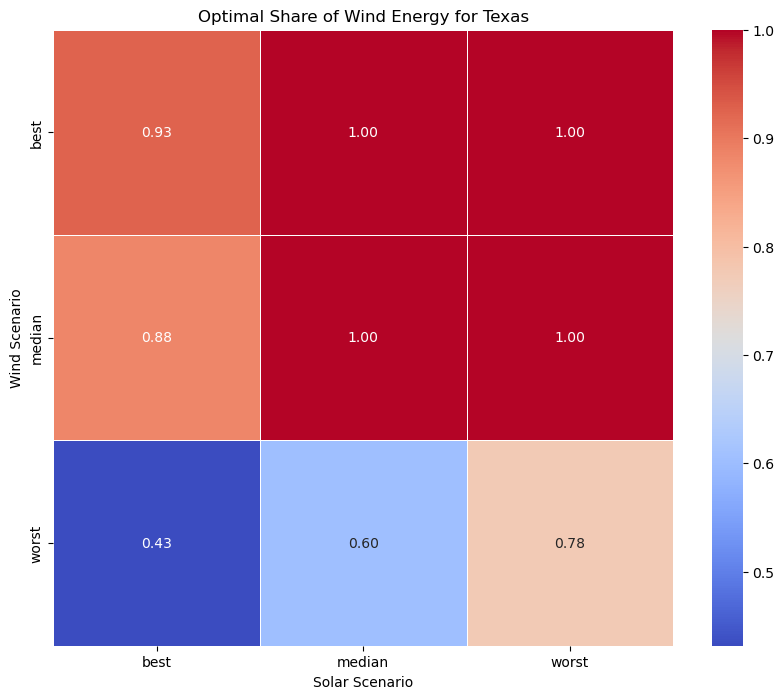

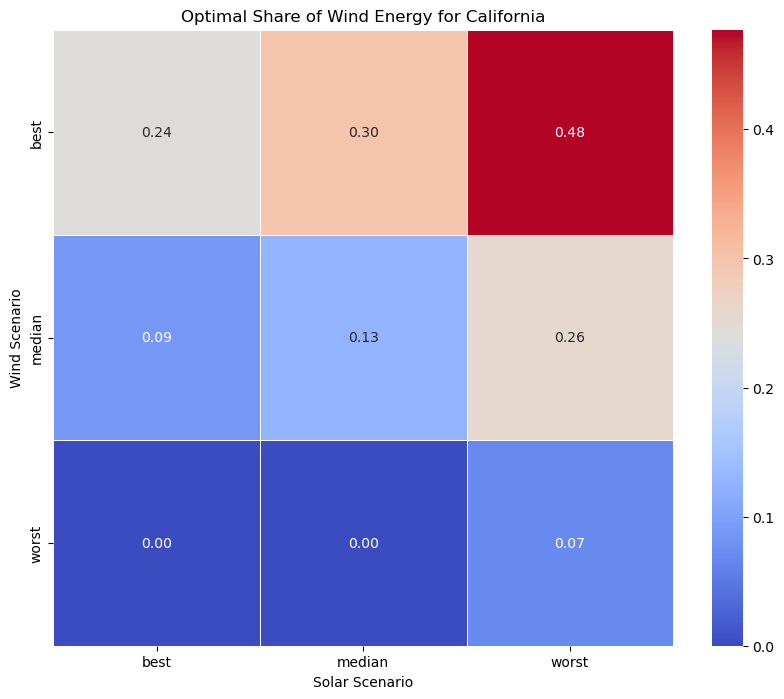

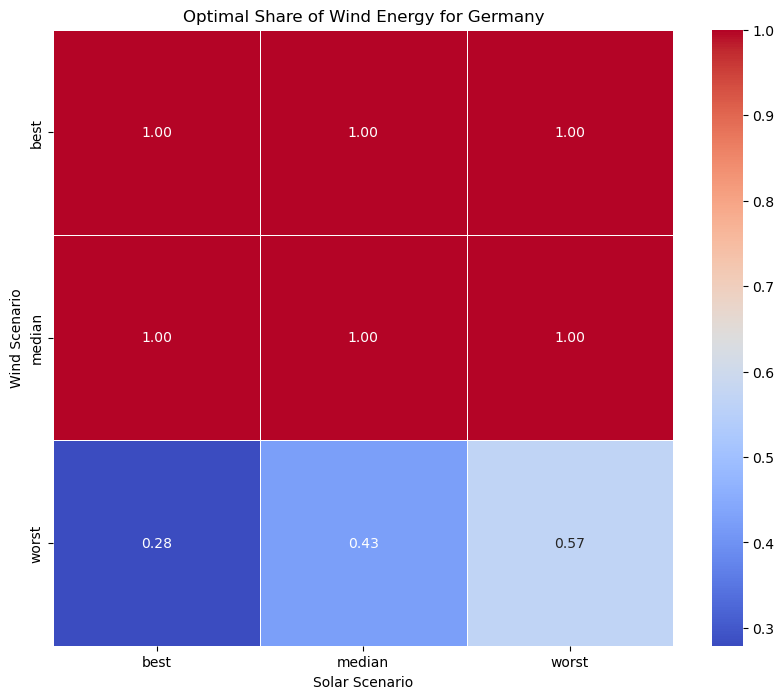

In [12]:
data = []
for (state, wind_scenario, solar_scenario), (k_e_w, k_e_s, _) in results.items():
    # Retrieve scenario-specific CFs
    CF_wind = combined_renewables[state][wind_scenario]['wind']
    CF_solar = combined_renewables[state][solar_scenario]['solar']

    # Calculate combined system cost parameters
    SP_e = (variables["SP_e_w"] * k_e_w + variables["SP_e_s"] * k_e_s) / (k_e_w + k_e_s)
    F_ei = (variables["F_ei_w"] * k_e_w + variables["F_ei_s"] * k_e_s) / (k_e_w + k_e_s)
    W_ei = (variables["W_ei_w"] * k_e_w + variables["W_ei_s"] * k_e_s) / (k_e_w + k_e_s)
    k_e = k_e_w + k_e_s  # Total capacity fraction
    CF_e_t = (k_e_w * CF_wind + k_e_s * CF_solar) / (k_e_w + k_e_s)  # Correct calculation of CF_e_t using scenario-specific CFs

    # Append data including the new parameters
    data.append([
        state, wind_scenario, solar_scenario, 
        k_e_w, k_e_s, 
        SP_e, F_ei, W_ei, k_e, CF_e_t
    ])

# Create DataFrame with additional columns for the new parameters
df_results = pd.DataFrame(data, columns=[
    'State', 'Wind Scenario', 'Solar Scenario', 
    'k_e_w', 'k_e_s', 
    'SP_e', 'F_ei', 'W_ei', 'k_e', 'CF_e_t'
])

# Optionally set MultiIndex for better data organization
df_results.set_index(['State', 'Wind Scenario', 'Solar Scenario'], inplace=True)


# Function to plot heatmaps for each state
def plot_heatmaps(df, value_column, title):
    states = df.index.get_level_values(0).unique()
    for state in states:
        state_df = df.xs(state, level='State')
        pivot_table = state_df.pivot_table(index='Wind Scenario', columns='Solar Scenario', values=value_column)
        plt.figure(figsize=(10, 8))
        sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title(f'{title} for {state}')
        plt.xlabel('Solar Scenario')
        plt.ylabel('Wind Scenario')
        plt.show()

# Call the function to plot heatmaps for k_e_w
plot_heatmaps(df_results, 'k_e_w', 'Optimal Share of Wind Energy')

In [13]:
def plot_and_save_heatmaps(df, value_column, title, path_figures, version):
    states = df.index.get_level_values(0).unique()
    for state in states:
        plt.figure(figsize=(10, 8))
        state_df = df.xs(state, level='State')
        pivot_table = state_df.pivot_table(index='Wind Scenario', columns='Solar Scenario', values=value_column)
        sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title(f'{title} for {state}')
        plt.xlabel('Solar Scenario')
        plt.ylabel('Wind Scenario')
        figure_path = os.path.join(path_figures, f'{title.replace(" ", "_")}_{state}_{version}.pdf')
        plt.savefig(figure_path, bbox_inches="tight")  # Save each plot right after creating it
        plt.close()  # Close the plot after saving to free up memory

# Call the function to plot and save heatmaps
# plot_and_save_heatmaps(df_results, 'k_e_w', 'Optimal Share of Wind Energy', path_figures, version)


In [14]:
# Export
file_path = os.path.join(path_inputs, 'optimized_renewables.pkl')
df_results.to_pickle(file_path)

print(f"Optimized configurations saved to: {file_path}")

Optimized configurations saved to: C:\Users\phili\OneDrive - uni-mannheim.de\My Projects\Low Carbon Hydrogen Project\Model\Python\02 Inputs\optimized_renewables.pkl


In [15]:
# # Experiment: Add a "none, none" scenario - does not work with the contour plots for now.
# results = {}

# for state in states:
#     # First wind
#     for wind_scenario in scenarios:
#         # get CFs
#         CF_wind = combined_renewables[state][wind_scenario]['wind']
        
#         # 2nd solar
#         for solar_scenario in scenarios:
#             # With Cfs
#             CF_solar = combined_renewables[state][solar_scenario]['solar']

#             # combined objective function: cost (low) + CF (high)
#             def combined_objective(x):
#                 k_e_w, k_e_s = x
#                 CF_e_t_w = k_e_w * np.mean(CF_wind)
#                 CF_e_t_s = k_e_s * np.mean(CF_solar)
#                 hourly_CF = k_e_w * CF_wind + k_e_s * CF_solar
                
#                 LCOE_w = LCOE(variables['F_ei_w'], variables['W_ei_w'], variables['SP_e_w'], CF_e_t_w, parameters['L'], parameters['gamma'], parameters['Delta_e'])
#                 LCOE_s = LCOE(variables['F_ei_s'], variables['W_ei_s'], variables['SP_e_s'], CF_e_t_s, parameters['L'], parameters['gamma'], parameters['Delta_e'])
#                 total_LCOE = k_e_w * LCOE_w + k_e_s * LCOE_s
                
#                 weight_LCOE = 1
#                 weight_CF = 1
#                 cf_penalty = np.sum((1 - hourly_CF)**2)

#                 return weight_LCOE * total_LCOE + weight_CF * cf_penalty

#             # optimization
#             initial_guess = [0.5, 0.5]
#             bounds = [(0, 1), (0, 1)]
#             constraints = [{'type': 'eq', 'fun': lambda x: x[0] + x[1] - 1}]
#             result = minimize(combined_objective, initial_guess, bounds=bounds, constraints=constraints)
            
#             # Store results
#             results[(state, wind_scenario, solar_scenario)] = (result.x[0], result.x[1], result.fun)

# # Add the 0% Renewable Scenario for all states
# for state in states:
#     wind_scenario = 'None'
#     solar_scenario = 'None'
#     k_e_w = 0
#     k_e_s = 0
#     SP_e = 0
#     F_ei = 0
#     W_ei = 0
#     k_e = 0
#     CF_e_t = np.zeros(8760)  # Assuming an hourly capacity factor vector filled with zeros

#     results[(state, wind_scenario, solar_scenario)] = (k_e_w, k_e_s, SP_e, F_ei, W_ei, k_e, CF_e_t)

# # Combine all results for export
# data = []
# for (state, wind_scenario, solar_scenario), values in results.items():
#     if wind_scenario == 'None' and solar_scenario == 'None':
#         k_e_w, k_e_s, SP_e, F_ei, W_ei, k_e, CF_e_t = values
#     else:
#         k_e_w, k_e_s, _ = values
#         # Retrieve scenario-specific CFs
#         CF_wind = combined_renewables[state][wind_scenario]['wind']
#         CF_solar = combined_renewables[state][solar_scenario]['solar']

#         # Calculate combined system cost parameters
#         SP_e = (variables["SP_e_w"] * k_e_w + variables["SP_e_s"] * k_e_s) / (k_e_w + k_e_s)
#         F_ei = (variables["F_ei_w"] * k_e_w + variables["F_ei_s"] * k_e_s) / (k_e_w + k_e_s)
#         W_ei = (variables["W_ei_w"] * k_e_w + variables["W_ei_s"] * k_e_s) / (k_e_w + k_e_s)
#         k_e = k_e_w + k_e_s  # Total capacity fraction
#         CF_e_t = (k_e_w * CF_wind + k_e_s * CF_solar) / (k_e_w + k_e_s)  # Correct calculation of CF_e_t using scenario-specific CFs

#     # Append data including the new parameters
#     data.append([
#         state, wind_scenario, solar_scenario,
#         k_e_w, k_e_s,
#         SP_e, F_ei, W_ei, k_e, CF_e_t
#     ])

# # Create DataFrame with additional columns for the new parameters
# df_results = pd.DataFrame(data, columns=[
#     'State', 'Wind Scenario', 'Solar Scenario',
#     'k_e_w', 'k_e_s',
#     'SP_e', 'F_ei', 'W_ei', 'k_e', 'CF_e_t'
# ])

# # Optionally set MultiIndex for better data organization
# df_results.set_index(['State', 'Wind Scenario', 'Solar Scenario'], inplace=True)

# # Export the DataFrame
# file_path = os.path.join(path_inputs, 'optimized_renewables.pkl')
# df_results.to_pickle(file_path)

# print(f"Optimized configurations saved to: {file_path}")


In [16]:
# # Optimal Renewable Portfolio
# parameters = f_parameters(T, d_i, r, x, alpha_f, alpha_s, m, ITC_SP_e, ITC_SP_h, PTC_vector, PTC_h_vector, PTC_grid_vector, 1)

# # Define necessary parameters
# p_s_t_CA = variables['p_s_t_CA']
# p_s_t_TX = variables['p_s_t_TX']
# p_s_t_DE = variables['p_s_t_DE']
# disc = parameters['disc']
# x_vect = parameters['x_vect']
# PTC_vector = parameters['PTC_vector']
# m = parameters['m']
# L = parameters['L']
# alpha = parameters['alpha']

# # Gamma_e_vector = np.array([1] * len(PTC_vector)) # later add the one from the revenue function?! or move
# disc_degr = parameters['disc_degr']
# # print(PTC_vector)

# # Define the LROE function
# def LROE(m, disc, x_vect, CF_e, p_s_vector, Gamma_e_vector, PTC_vector, disc_degr):
#     numerator = m * np.sum(disc * x_vect * CF_e * (p_s_vector * Gamma_e_vector + PTC_vector))
#     denominator = m * disc_degr * CF_e
#     return numerator / denominator if denominator != 0 else 0

# # Define the LCOE function
# def LCOE(F_e, w_ei, SP_e, CF_e_t, L, gamma, Delta_e):
#     years = np.arange(len(T))
#     disc = gamma ** years
#     CF_e = np.mean(CF_e_t)  # CF for renewable source(s)
#     f_e = np.sum(F_e * disc) / (CF_e * L)
#     c_e = SP_e / (CF_e * L)
#     return w_ei + f_e + Delta_e * c_e

# # Define the NPV function
# def NPV(alpha, L, CF_e, k_e, LROE, LCOE):
#     return (1 - alpha) * (L * CF_e * k_e * (LROE - LCOE))

# # Combined objective function to maximize NPV
# def combined_objective(x, CF_wind, CF_solar, p_s_vector, parameters):
#     k_e_w, k_e_s = x
#     CF_e_w = np.mean(CF_wind)
#     CF_e_s = np.mean(CF_solar)
#     CF_e_t_w = k_e_w * CF_e_w
#     CF_e_t_s = k_e_s * CF_e_s
    
#     # Calculate LROE for wind and solar
#     LROE_w = LROE(m, disc, x_vect, CF_e_t_w, p_s_vector, Gamma_e_vector, PTC_vector, disc_degr)
#     LROE_s = LROE(m, disc, x_vect, CF_e_t_s, p_s_vector, Gamma_e_vector, PTC_vector, disc_degr)
    
#     # Calculate LCOE for both components
#     LCOE_w = LCOE(variables['F_ei_w'], variables['W_ei_w'], variables['SP_e_w'], CF_e_t_w, parameters['L'], parameters['gamma'], parameters['Delta_e'])
#     LCOE_s = LCOE(variables['F_ei_s'], variables['W_ei_s'], variables['SP_e_s'], CF_e_t_s, parameters['L'], parameters['gamma'], parameters['Delta_e'])
# #     print("LCOE_w:", LCOE_w)
# #     print("LCOE_s:", LCOE_s)
#     # total_LCOE = k_e_w * LCOE_w + k_e_s * LCOE_s
    
#     # Calculate NPV for wind and solar
#     NPV_w = NPV(alpha, L, CF_e_t_w, k_e_w, LROE_w, LCOE_w)
#     NPV_s = NPV(alpha, L, CF_e_t_s, k_e_s, LROE_s, LCOE_s)
    
#     # Total NPV
#     total_NPV = NPV_w + NPV_s
    
#     return -total_NPV  # Negate because we use minimize function

# # Constraints and bounds
# constraints = [{'type': 'eq', 'fun': lambda x: x[0] + x[1] - 1}]
# bounds = [(0, 1), (0, 1)]

# # Initial guess
# initial_guess = [0.5, 0.5]

# # Perform optimization for each state and scenario
# results = {}
# for state in combined_renewables.keys():
#     if state == 'California':
#         p_s_t = variables['p_s_t_CA']
#         p_s = np.mean(p_s_t)
#         p_s_vector = np.array([p_s] * len(PTC_vector))
#     elif state == 'Texas':
#         p_s_t = variables['p_s_t_TX']
#         p_s = np.mean(p_s_t)
#         p_s_vector = np.array([p_s] * len(PTC_vector))
#     elif state == 'Germany':
#         p_s_t = variables['p_s_t_DE']
#         p_s = np.mean(p_s_t)
#         p_s_vector = np.array([p_s] * len(PTC_vector))

#     for wind_scenario in scenarios:
#         for solar_scenario in scenarios:
#             # Get capacity factors for the current scenario
#             CF_wind = combined_renewables[state][wind_scenario]['wind']
#             CF_solar = combined_renewables[state][solar_scenario]['solar']
            
#             CF_e = np.mean(CF_e_t)
#             if CF_e == 0:  # Remove error of dividing by zero
#                 epsilon_e_t = np.ones(len(CF_e_t)) * 0
#             else:
#                 epsilon_e_t = CF_e_t / CF_e
#             p_s = np.mean(p_s_t)
#             mu_s_t = p_s_t / p_s
#             Gamma_e = np.mean(epsilon_e_t * mu_s_t)  # Super dominant!!! Why?
#             Gamma_e_vector = np.array([Gamma_e] * len(PTC_vector))
            
#             # Perform optimization
#             result = minimize(combined_objective, initial_guess, bounds=bounds, constraints=constraints, args=(CF_wind, CF_solar, p_s_vector, parameters))
            
#             # Store results
#             results[(state, wind_scenario, solar_scenario)] = (result.x[0], result.x[1], -result.fun)
            
#             print(f"Optimal composition for {state}, {wind_scenario} wind + {solar_scenario} solar:")
#             print(f"Optimal k_e_w: {result.x[0]}, Optimal k_e_s: {result.x[1]}")
#             print(f"NPV: {-result.fun}")
#             print("-------------------------------------------------------")

In [17]:
# Define more necessary parameters

parameters = f_parameters(T, d_i, r, x, alpha_f, alpha_s, m, ITC_SP_e, ITC_SP_h, PTC_vector, PTC_h_vector, PTC_grid_vector, 1)

# Define necessary parameters
p_s_t_CA = variables['p_s_t_CA']
p_s_t_TX = variables['p_s_t_TX']
p_s_t_DE = variables['p_s_t_DE']
disc = parameters['disc']
x_vect = parameters['x_vect']
PTC_vector = parameters['PTC_vector']
m = parameters['m']
L = parameters['L']
alpha = parameters['alpha']

# Gamma_e_vector = np.array([1] * len(PTC_vector)) # later add the one from the revenue function?! or move
disc_degr = parameters['disc_degr']


In [18]:
# Define the LROE function
def LROE(m, disc, x_vect, CF_e, p_s_vector, Gamma_e_vector, PTC_vector, disc_degr):
    numerator = m * np.sum(disc * x_vect * CF_e * (p_s_vector * Gamma_e_vector + PTC_vector))
    denominator = m * disc_degr * CF_e
    return numerator / denominator if denominator != 0 else 0

# Define the LCOE function
def LCOE(F_e, w_ei, SP_e, CF_e_t, L, gamma, Delta_e):
    years = np.arange(len(T))
    disc = gamma ** years
    CF_e = np.mean(CF_e_t)
    f_e = np.sum(F_e * disc) / (CF_e * L)
    c_e = SP_e / (CF_e * L)
    return w_ei + f_e + Delta_e * c_e

# Define the NPV function
def NPV(alpha, L, CF_e, k_e, LROE, LCOE):
    return (1 - alpha) * (L * CF_e * k_e * (LROE - LCOE))

# Updated combined objective function
def combined_objective(rho, CF_wind, CF_solar, p_s_vector, Gamma_e_vector, parameters, variables):
    # Adjust cost parameters based on rho
    SP_e = (variables["SP_e_w"] * rho + variables["SP_e_s"] * (1 - rho)) / (rho + (1 - rho)) if rho + (1 - rho) != 0 else 0
    F_ei = (variables["F_ei_w"] * rho + variables["F_ei_s"] * (1 - rho)) / (rho + (1 - rho)) if rho + (1 - rho) != 0 else 0
    W_ei = (variables["W_ei_w"] * rho + variables["W_ei_s"] * (1 - rho)) / (rho + (1 - rho)) if rho + (1 - rho) != 0 else 0
    k_e = 1  # Total capacity factor is now 1, as rho represents the proportion

    CF_e_t = CF_wind * rho + CF_solar * (1 - rho)
    CF_e = np.mean(CF_e_t)
    
    # Calculate LROE for the combined renewable source
    LROE_combined = LROE(m, disc, x_vect, CF_e, p_s_vector, Gamma_e_vector, PTC_vector, disc_degr)
    
    # Calculate LCOE for the combined renewable source
    LCOE_combined = LCOE(F_ei, W_ei, SP_e, CF_e_t, parameters['L'], parameters['gamma'], parameters['Delta_e'])
    
    # Calculate NPV for the combined renewable source
    NPV_combined = NPV(alpha, L, CF_e, k_e, LROE_combined, LCOE_combined)
    
    return -NPV_combined  # Negate because we use minimize function

# Constraints and bounds
bounds = [(0, 1)]  # rho is between 0 and 1

# Perform optimization for each state and scenario
results = {}
for state in combined_renewables.keys():
    if state == 'California':
        p_s_t = variables['p_s_t_CA']
        p_s = np.mean(p_s_t)
        p_s_vector = np.array([p_s] * len(PTC_vector))
    elif state == 'Texas':
        p_s_t = variables['p_s_t_TX']
        p_s = np.mean(p_s_t)
        p_s_vector = np.array([p_s] * len(PTC_vector))        
    elif state == 'Germany':        
        p_s_t = variables['p_s_t_DE']
        p_s = np.mean(p_s_t)
        p_s_vector = np.array([p_s] * len(PTC_vector))    


    for wind_scenario in scenarios:
        for solar_scenario in scenarios:
            # Get capacity factors for the current scenario
            CF_wind = combined_renewables[state][wind_scenario]['wind']
            CF_solar = combined_renewables[state][solar_scenario]['solar']
            
            # Calculate initial Gamma_e (will be updated in each optimization step)
            CF_e_t_initial = CF_wind * 0.5 + CF_solar * 0.5  # Initial guess 
            epsilon_e_t_initial = CF_e_t_initial / np.mean(CF_e_t_initial)
            mu_s_t = p_s_t / p_s
            Gamma_e_initial = np.mean(epsilon_e_t_initial * mu_s_t)
            Gamma_e_vector_initial = np.array([Gamma_e_initial] * len(PTC_vector))
            # print("Gamma_e_initial", Gamma_e_initial)
            
            # Define a wrapper function to update Gamma_e in each iteration
            def objective_wrapper(rho):
                CF_e_t = CF_wind * rho + CF_solar * (1 - rho)
                epsilon_e_t = CF_e_t / np.mean(CF_e_t)
                Gamma_e = np.mean(epsilon_e_t * mu_s_t)
                print("Gamma_e", Gamma_e)
                Gamma_e_vector = np.array([Gamma_e] * len(PTC_vector))
                return combined_objective(rho, CF_wind, CF_solar, p_s_vector, Gamma_e_vector, parameters, variables)
            
            # Perform optimization
            result = minimize(objective_wrapper, 0.5, bounds=bounds)
            
            # Store results
            optimal_rho = result.x[0]
            optimal_npv = -result.fun
            results[(state, wind_scenario, solar_scenario)] = (optimal_rho, optimal_npv)
            
            print(f"Optimal composition for {state}, {wind_scenario} wind + {solar_scenario} solar:")
            print(f"Optimal rho (proportion of wind): {optimal_rho}")
            print(f"NPV: {optimal_npv}")
            print("-------------------------------------------------------")

Gamma_e 1.0025293923150627
Gamma_e 1.0025293914826072
Gamma_e 1.053855040487659
Gamma_e 1.0538550392218513
Optimal composition for Texas, best wind + best solar:
Optimal rho (proportion of wind): 0.0
NPV: 288.74659742149606
-------------------------------------------------------
Gamma_e 1.0154288543494985
Gamma_e 1.01542885311421
Gamma_e 0.9675241720663229
Gamma_e 0.9675241728094233
Optimal composition for Texas, best wind + median solar:
Optimal rho (proportion of wind): 1.0
NPV: 270.83973813005036
-------------------------------------------------------
Gamma_e 0.9998021296745775
Gamma_e 0.9998021287880399
Gamma_e 0.9675241720663229
Gamma_e 0.9675241725364064
Optimal composition for Texas, best wind + worst solar:
Optimal rho (proportion of wind): 1.0
NPV: 270.83973813005036
-------------------------------------------------------
Gamma_e 0.9675970954842553
Gamma_e 0.9675970939806849
Gamma_e 1.053855040487659
Gamma_e 1.0538550385082552
Optimal composition for Texas, median wind + best 

In [19]:
data_2 = []
for (state, wind_scenario, solar_scenario), (rho, npv) in results.items():
    # Retrieve scenario-specific CFs
    CF_wind = combined_renewables[state][wind_scenario]['wind']
    CF_solar = combined_renewables[state][solar_scenario]['solar']
    
    # Calculate combined system cost parameters
    SP_e = (variables["SP_e_w"] * rho + variables["SP_e_s"] * (1 - rho)) / (rho + (1 - rho)) if rho + (1 - rho) != 0 else 0
    F_ei = (variables["F_ei_w"] * rho + variables["F_ei_s"] * (1 - rho)) / (rho + (1 - rho)) if rho + (1 - rho) != 0 else 0
    W_ei = (variables["W_ei_w"] * rho + variables["W_ei_s"] * (1 - rho)) / (rho + (1 - rho)) if rho + (1 - rho) != 0 else 0
    
    k_e = 1  # Total capacity factor is now 1, as rho represents the proportion
    CF_e_t = CF_wind * rho + CF_solar * (1 - rho)
    
    # Append data
    data_2.append([
        state, wind_scenario, solar_scenario, 
        rho, 1 - rho,  # k_e_w and k_e_s are now represented by rho and (1-rho)
        SP_e, F_ei, W_ei, k_e, CF_e_t, npv, CF_wind, CF_solar
    ])

# Create DataFrame with additional columns for the new parameters
df_results_2 = pd.DataFrame(data_2, columns=[
    'State', 'Wind Scenario', 'Solar Scenario', 
    'rho (wind proportion)', 'solar proportion', 
    'SP_e', 'F_ei', 'W_ei', 'k_e', 'CF_e_t', 'NPV', 'CF_wind', 'CF_solar'
])

# Set MultiIndex for better data organization
df_results_2.set_index(['State', 'Wind Scenario', 'Solar Scenario'], inplace=True)

In [20]:
# Export
file_path = os.path.join(path_inputs, 'optimized_renewables_2.pkl')
df_results_2.to_pickle(file_path)

print(f"Optimized configurations saved to: {file_path}")

Optimized configurations saved to: C:\Users\phili\OneDrive - uni-mannheim.de\My Projects\Low Carbon Hydrogen Project\Model\Python\02 Inputs\optimized_renewables_2.pkl


In [65]:
## Version not working currently 
# stop
df_results_2

rho (wind proportion)  \
State      Wind Scenario Solar Scenario                          
Texas      best          best                              0.0   
                         median                            1.0   
                         worst                             1.0   
           median        best                              0.0   
                         median                            0.0   
                         worst                             1.0   
           worst         best                              0.0   
                         median                            0.0   
                         worst                             0.0   
California best          best                              0.0   
                         median                            0.0   
                         worst                             0.0   
           median        best                              0.0   
                         median                            0.0   
                         worst                             0.0   
           worst         best                              0.0   
                         median                            0.0   
                         worst                             0.0   
Germany    best          best                              1.0   
                         median                            1.0   
                         worst                             1.0   
           median        best                              0.0   
                         median                            0.0   
                         worst                             1.0   
           worst         best                              0.0   
                         median                            0.0   
                         worst                             0.0   

                                         solar proportion    SP_e    F_ei  \
State      Wind Scenario Solar Scenario                                     
Texas      best          best                         1.0  1133.0   5.133   
                         median                       0.0  1609.0  12.840   
                         worst                        0.0  1609.0  12.840   
           median        best                         1.0  1133.0   5.133   
                         median                       1.0  1133.0   5.133   
                         worst                        0.0  1609.0  12.840   
           worst         best                         1.0  1133.0   5.133   
                         median                       1.0  1133.0   5.133   
                         worst                        1.0  1133.0   5.133   
California best          best                         1.0  1133.0   5.133   
                         median                       1.0  1133.0   5.133   
                         worst                        1.0  1133.0   5.133   
           median        best                         1.0  1133.0   5.133   
                         median                       1.0  1133.0   5.133   
                         worst                        1.0  1133.0   5.133   
           worst         best                         1.0  1133.0   5.133   
                         median                       1.0  1133.0   5.133   
                         worst                        1.0  1133.0   5.133   
Germany    best          best                         0.0  1609.0  12.840   
                         median                       0.0  1609.0  12.840   
                         worst                        0.0  1609.0  12.840   
           median        best                         1.0  1133.0   5.133   
                         median                       1.0  1133.0   5.133   
                         worst                        0.0  1609.0  12.840   
           worst         best                         1.0  1133.0   5.133   
                         median                

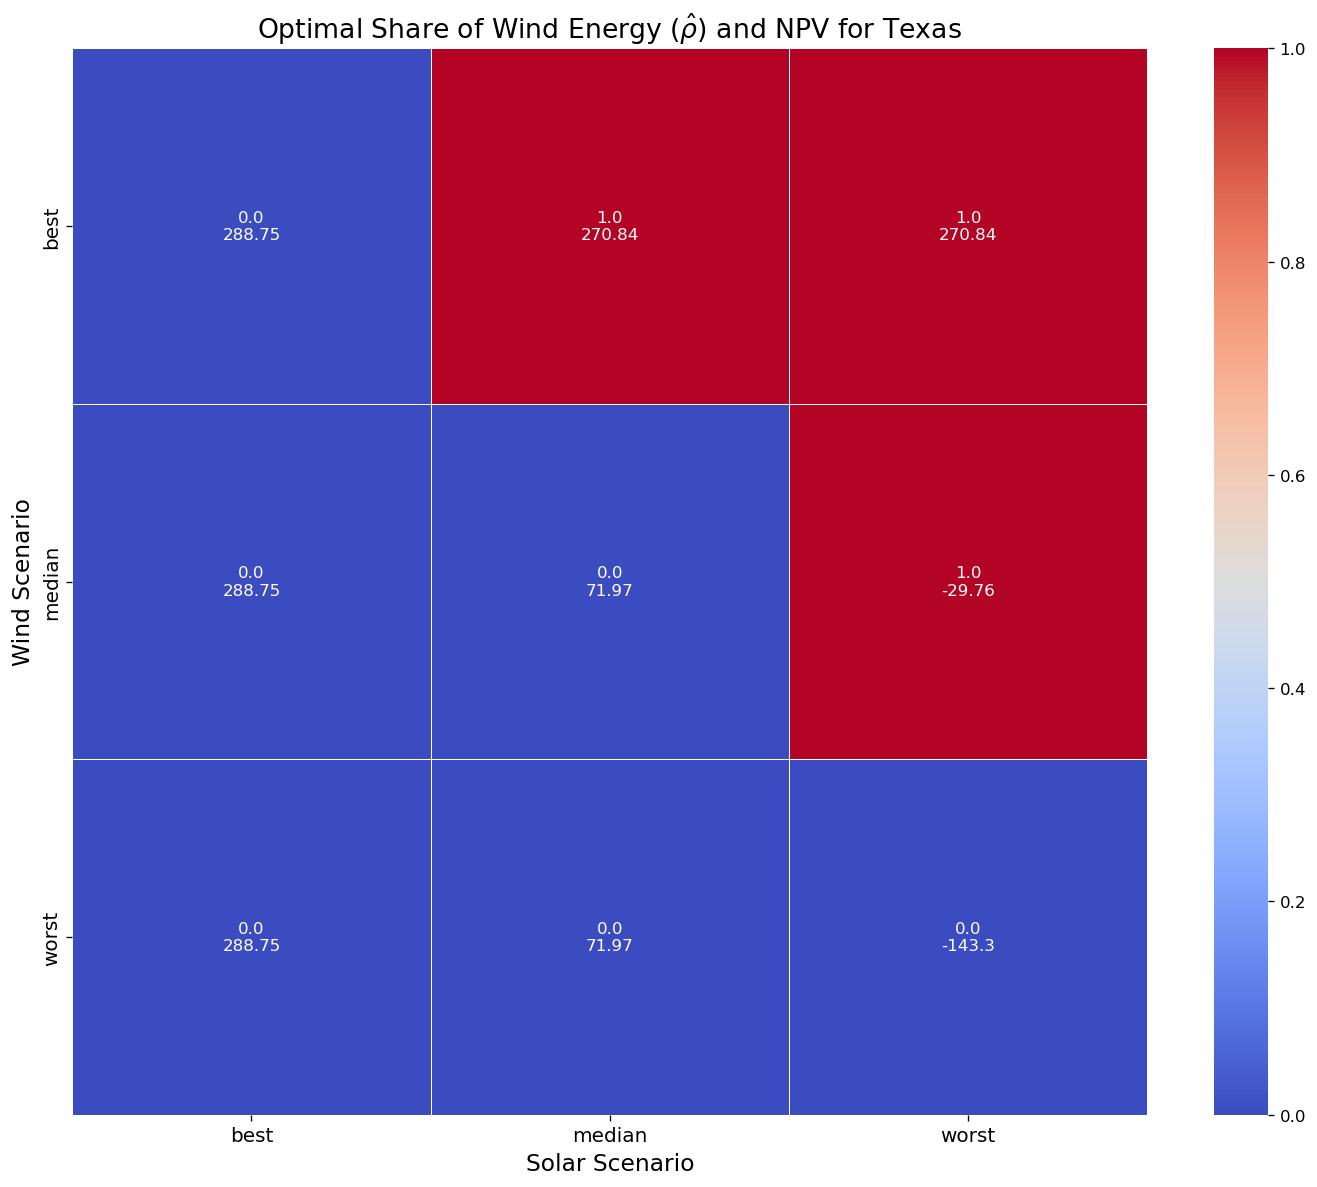

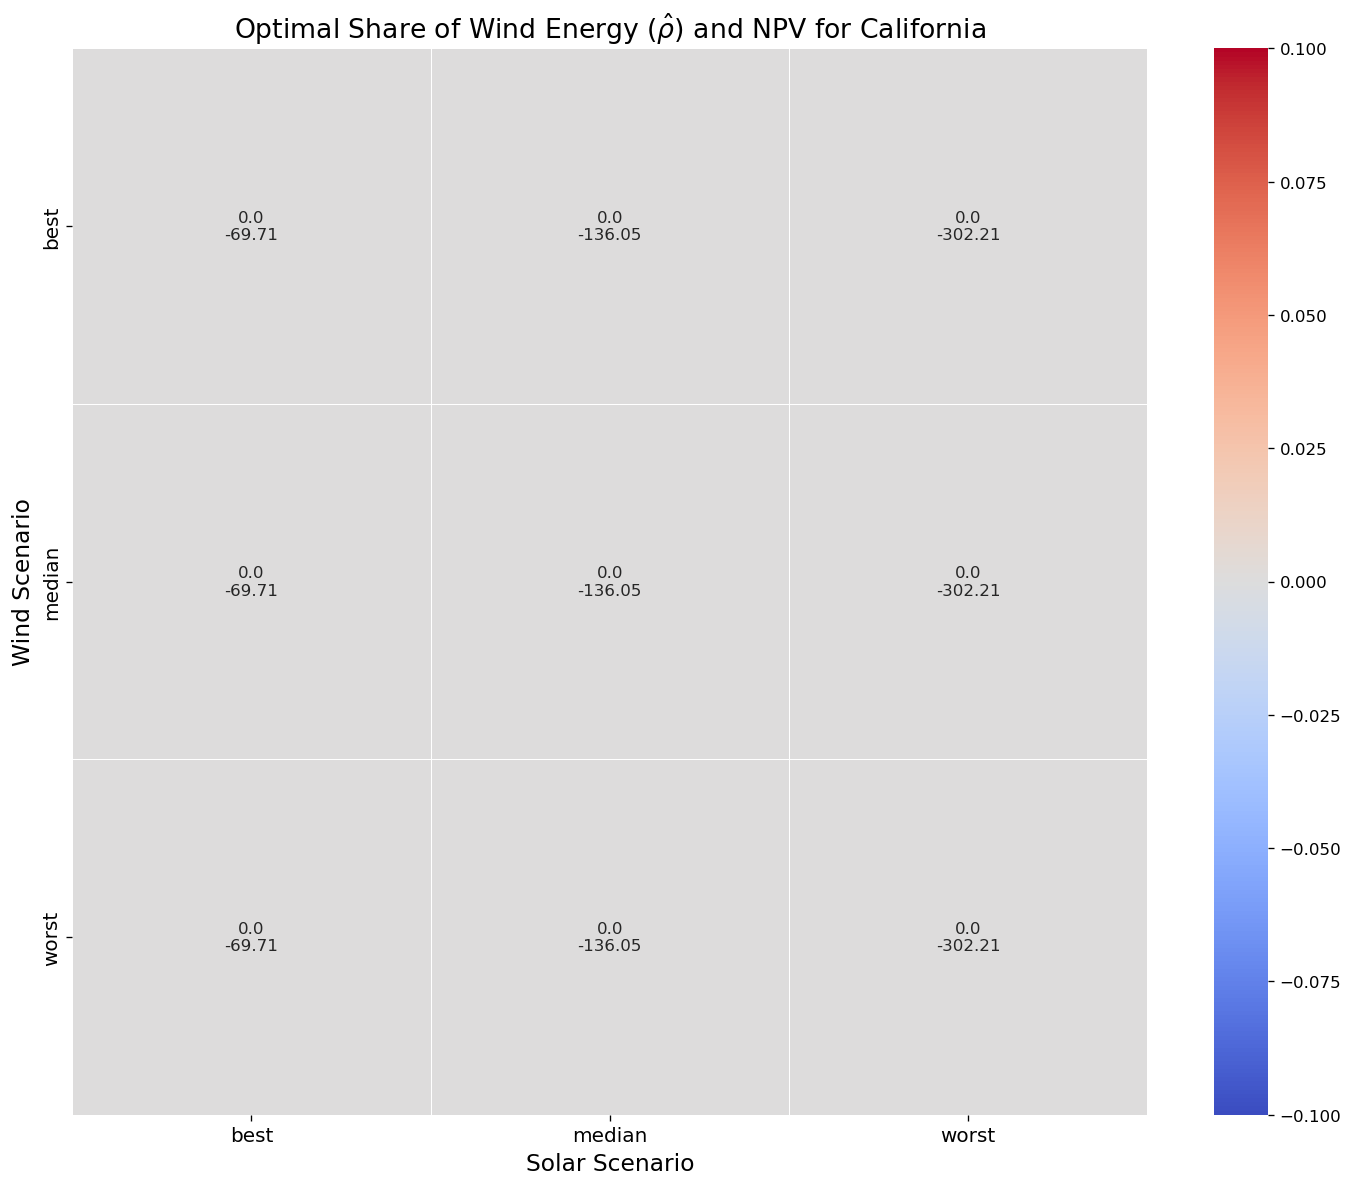

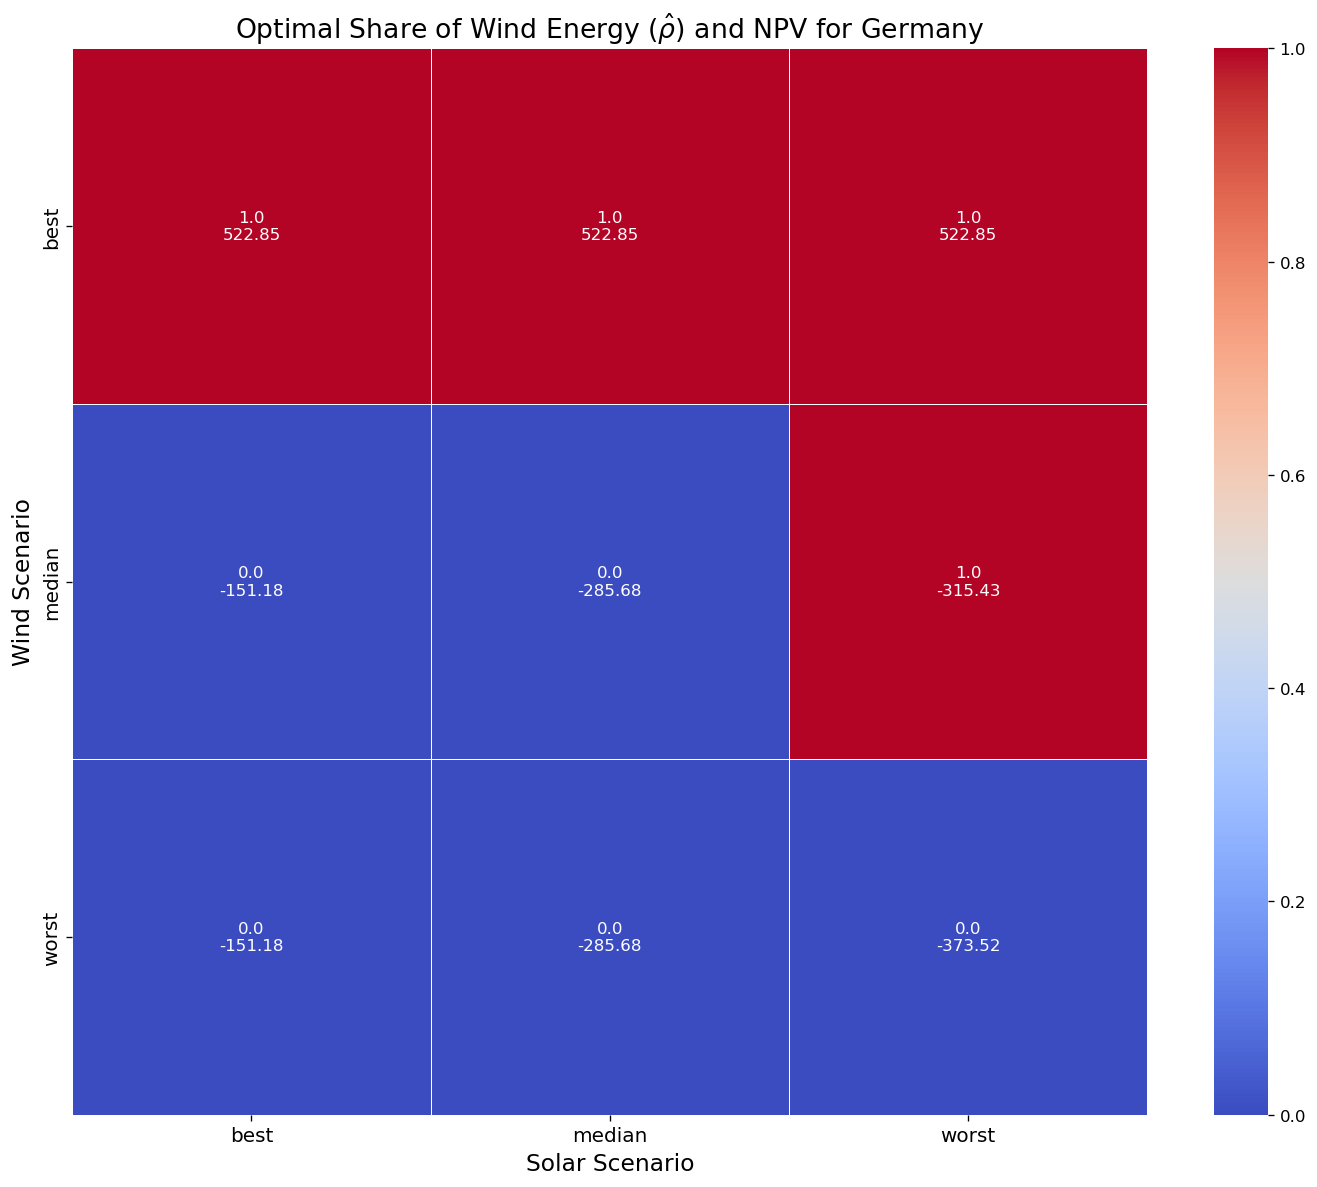

In [22]:
# heatmap
def plot_heatmaps(df, rho_column, npv_column, title):
    states = df.index.get_level_values(0).unique()
    for state in states:
        state_df = df.xs(state, level='State')
        pivot_table_rho = state_df.pivot_table(index='Wind Scenario', columns='Solar Scenario', values=rho_column).round(2)
        pivot_table_npv = state_df.pivot_table(index='Wind Scenario', columns='Solar Scenario', values=npv_column).round(2)
        
        combined_data = pivot_table_rho.astype(str) + '\n' + pivot_table_npv.astype(str)
        plt.figure(figsize=(12, 10), dpi=120)  # Increase DPI for better quality
        sns.heatmap(pivot_table_rho, annot=combined_data, fmt="", cmap='coolwarm', linewidths=.5, cbar=True, annot_kws={"size": 10})
        plt.title(f'{title} for {state}', fontsize=16)
        plt.xlabel('Solar Scenario', fontsize=14)
        plt.ylabel('Wind Scenario', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()  # Ensure all elements fit within the figure
        plt.show()

# Plot heatmaps for rho (wind proportion) and NPV together
plot_heatmaps(df_results_2, 'rho (wind proportion)', 'NPV', 'Optimal Share of Wind Energy ($\\hat{\\rho}$) and NPV')

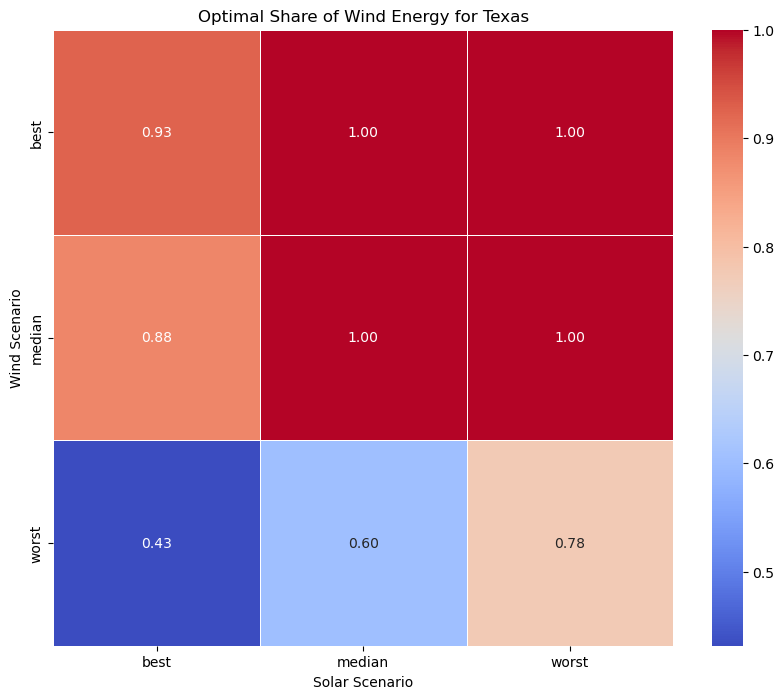

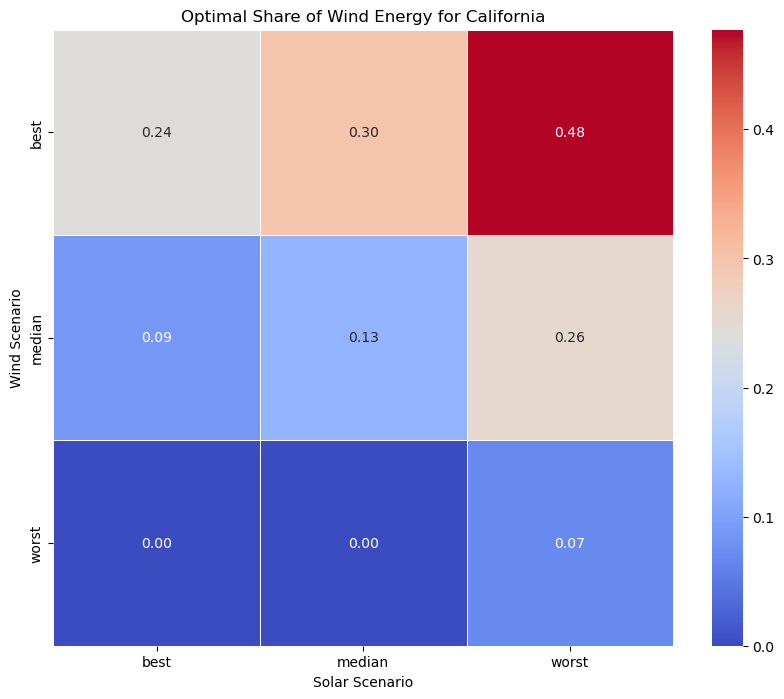

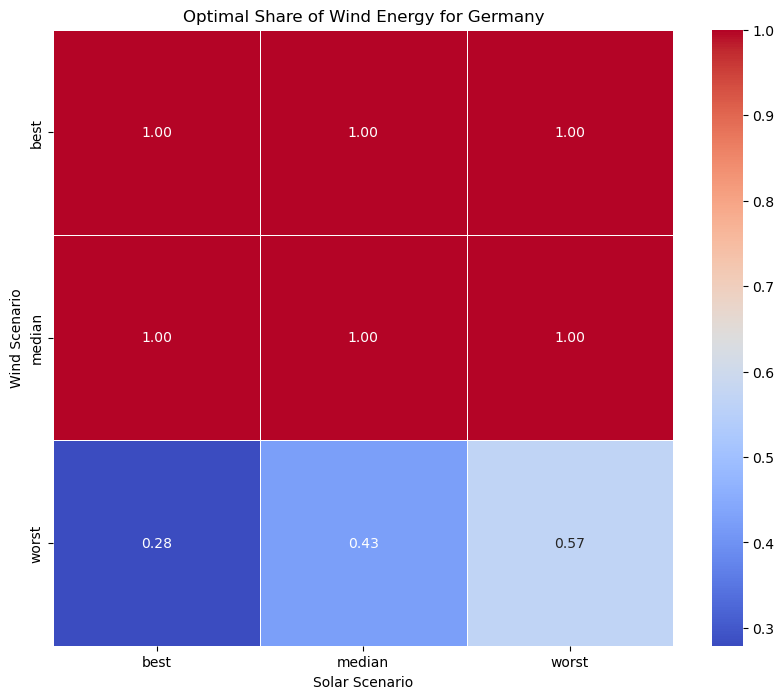

In [23]:
# Function to plot heatmaps for each state
def plot_heatmaps(df, value_column, title):
    states = df.index.get_level_values(0).unique()
    for state in states:
        state_df = df.xs(state, level='State')
        pivot_table = state_df.pivot_table(index='Wind Scenario', columns='Solar Scenario', values=value_column)
        plt.figure(figsize=(10, 8))
        sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title(f'{title} for {state}')
        plt.xlabel('Solar Scenario')
        plt.ylabel('Wind Scenario')
        plt.show()

# Call the function to plot heatmaps for k_e_w
plot_heatmaps(df_results, 'k_e_w', 'Optimal Share of Wind Energy')

In [24]:
# # Export results
# data = []
# for (state, wind_scenario, solar_scenario), (k_e_w, k_e_s, npv) in results.items():
#     CF_wind = combined_renewables[state][wind_scenario]['wind']
#     CF_solar = combined_renewables[state][solar_scenario]['solar']

#     SP_e = (variables["SP_e_w"] * k_e_w + variables["SP_e_s"] * k_e_s) / (k_e_w + k_e_s)
#     F_ei = (variables["F_ei_w"] * k_e_w + variables["F_ei_s"] * k_e_s) / (k_e_w + k_e_s)
#     W_ei = (variables["W_ei_w"] * k_e_w + variables["W_ei_s"] * k_e_s) / (k_e_w + k_e_s)
#     k_e = k_e_w + k_e_s
#     CF_e_t = (k_e_w * CF_wind + k_e_s * CF_solar) / (k_e_w + k_e_s)

#     data.append([
#         state, wind_scenario, solar_scenario,
#         k_e_w, k_e_s,
#         SP_e, F_ei, W_ei, k_e, CF_e_t, npv
#     ])

# df_results = pd.DataFrame(data, columns=[
#     'State', 'Wind Scenario', 'Solar Scenario',
#     'k_e_w', 'k_e_s',
#     'SP_e', 'F_ei', 'W_ei', 'k_e', 'CF_e_t', 'NPV'
# ])

# df_results.set_index(['State', 'Wind Scenario', 'Solar Scenario'], inplace=True)

# file_path = os.path.join(path_inputs, 'optimized_renewables_2.pkl')
# df_results.to_pickle(file_path)

# print(f"Optimized configurations saved to: {file_path}")


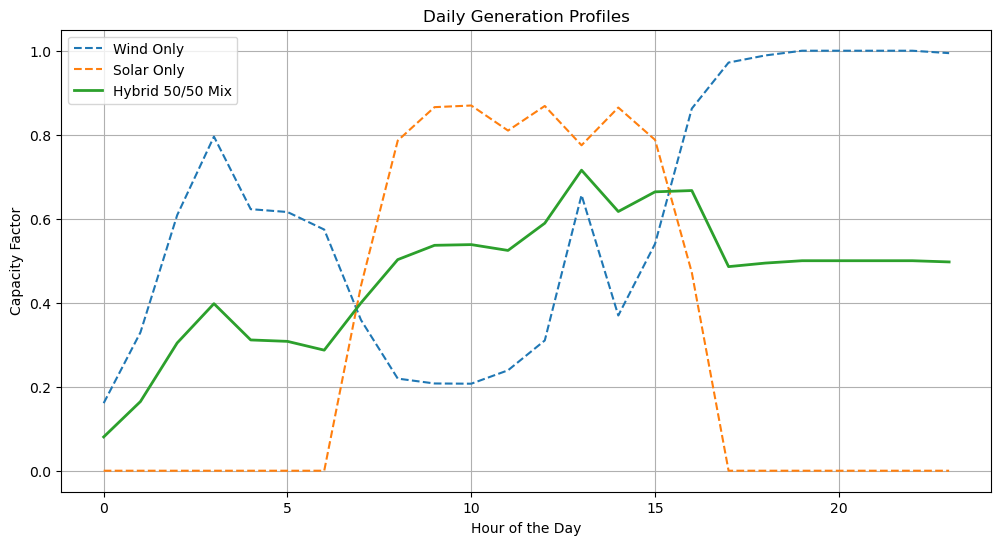

In [25]:
# Assuming hourly CF data is loaded or calculated
hours = np.arange(24)  # Example: one day
plt.figure(figsize=(12, 6))

# Plot each system's profile
plt.plot(hours, variables['CF_wind'][:24], label='Wind Only', linestyle='--')
plt.plot(hours, variables['CF_solar'][:24], label='Solar Only', linestyle='--')
plt.plot(hours, 0.5 * variables['CF_wind'][:24] + 0.5 * variables['CF_solar'][:24], label='Hybrid 50/50 Mix', linewidth=2)

plt.title('Daily Generation Profiles')
plt.xlabel('Hour of the Day')
plt.ylabel('Capacity Factor')
plt.legend()
plt.grid(True)
plt.show()

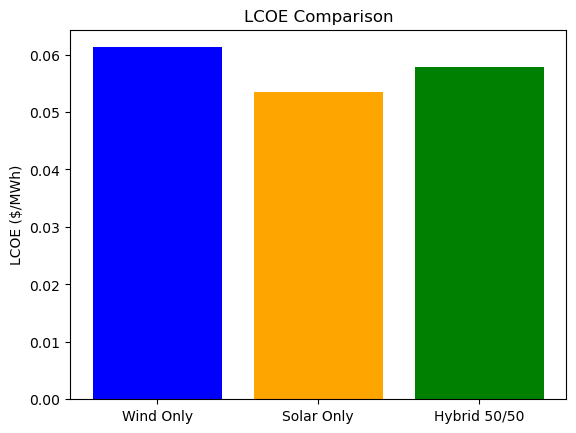

In [26]:
lcoe_wind = LCOE(variables["F_ei_w"], variables["W_ei_w"], variables["SP_e_w"], variables['CF_wind'], parameters['L'], parameters['gamma'], parameters['Delta_e'])
lcoe_solar = LCOE(variables["F_ei_s"], variables["W_ei_s"], variables["SP_e_s"], variables['CF_solar'], parameters['L'], parameters['gamma'], parameters['Delta_e'])
lcoe_hybrid = LCOE(0.5 * variables['F_ei_w'] + 0.5 * variables['F_ei_s'], 0.5 * variables['W_ei_w'] + 0.5 * variables['W_ei_s'], 0.5 * variables['SP_e_w'] + 0.5 * variables['SP_e_s'], 0.5 * variables['CF_wind'] + 0.5 * variables['CF_solar'], parameters['L'], parameters['gamma'], parameters['Delta_e'])

lcoe_values = [lcoe_wind, lcoe_solar, lcoe_hybrid]
labels = ['Wind Only', 'Solar Only', 'Hybrid 50/50']

plt.figure()
plt.bar(labels, lcoe_values, color=['blue', 'orange', 'green'])
plt.title('LCOE Comparison')
plt.ylabel('LCOE ($/MWh)')
plt.show()

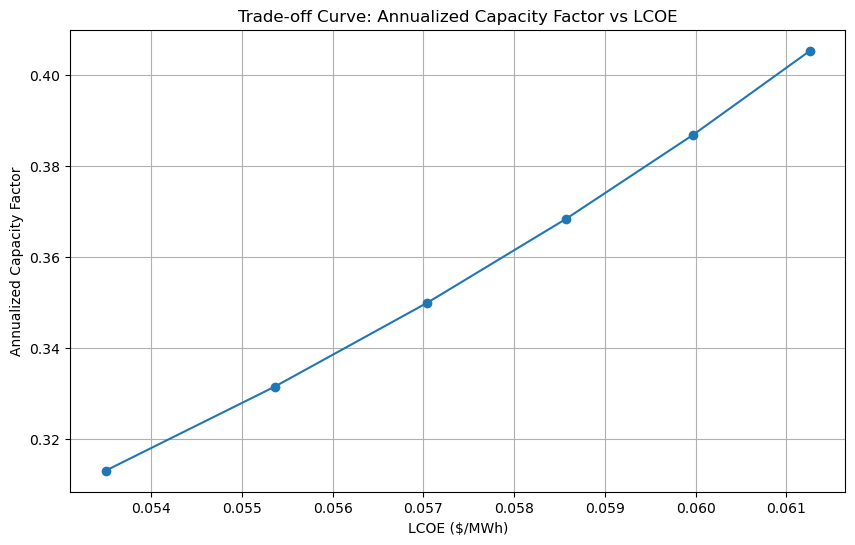

In [27]:
def calculate_annualized_CF(CF_array):
    return np.mean(CF_array)

# Setup for mix ratios and storage for results
mix_ratios = np.arange(0, 1.1, 0.2)  # Ratios from 0% to 100% wind in 20% steps
annualized_cfs = []
lcoe_values = []

# Loop through each mix ratio to calculate CF and LCOE
for ratio in mix_ratios:
    CF_hybrid = ratio * variables['CF_wind'] + (1 - ratio) * variables['CF_solar']
    annualized_cf = calculate_annualized_CF(CF_hybrid)
    annualized_cfs.append(annualized_cf)
    
    F_ei_hybrid = ratio * variables['F_ei_w'] + (1 - ratio) * variables['F_ei_s']
    W_ei_hybrid = ratio * variables['W_ei_w'] + (1 - ratio) * variables['W_ei_s']
    SP_e_hybrid = ratio * variables['SP_e_w'] + (1 - ratio) * variables['SP_e_s']

    lcoe_hybrid = LCOE(F_ei_hybrid, W_ei_hybrid, SP_e_hybrid, CF_hybrid, parameters['L'], parameters['gamma'], parameters['Delta_e'])
    lcoe_values.append(lcoe_hybrid)

# Plot the trade-off curve
plt.figure(figsize=(10, 6))
plt.plot(lcoe_values, annualized_cfs, marker='o', linestyle='-')
plt.title('Trade-off Curve: Annualized Capacity Factor vs LCOE')
plt.xlabel('LCOE ($/MWh)')
plt.ylabel('Annualized Capacity Factor')
plt.grid(True)
plt.show()


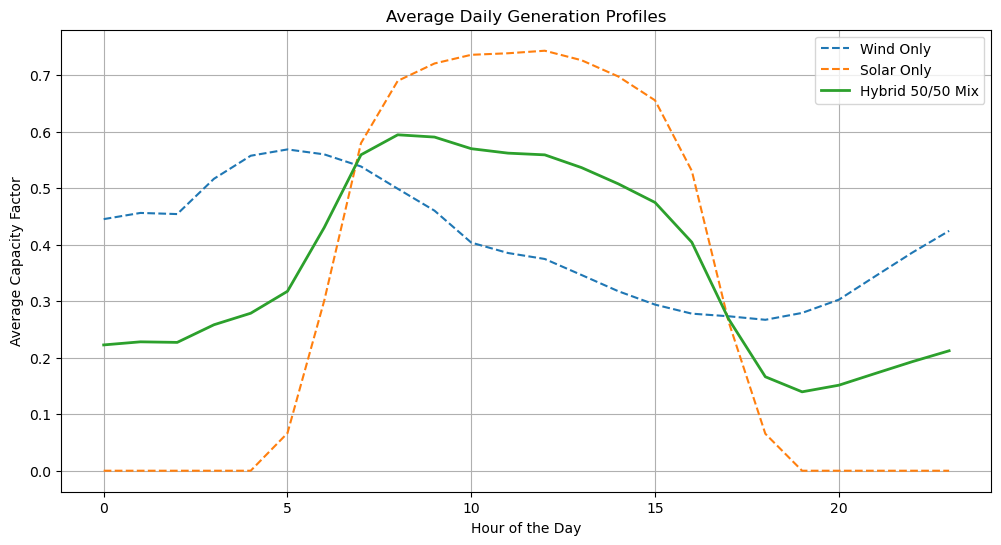

In [28]:
CF_wind = variables['CF_wind'].values
CF_solar = variables['CF_solar'].values

# Reshape to get daily averages (24 hours * 365 days)
daily_wind = CF_wind.reshape(-1, 24).mean(axis=0)
daily_solar = CF_solar.reshape(-1, 24).mean(axis=0)

# Calculate hybrid daily average 
daily_hybrid = 0.5 * daily_wind + 0.5 * daily_solar

# Plot the average daily profiles
plt.figure(figsize=(12, 6))
hours = np.arange(24)  # One day
plt.plot(hours, daily_wind, label='Wind Only', linestyle='--')
plt.plot(hours, daily_solar, label='Solar Only', linestyle='--')
plt.plot(hours, daily_hybrid, label='Hybrid 50/50 Mix', linewidth=2)
plt.title('Average Daily Generation Profiles')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Capacity Factor')
plt.legend()
plt.grid(True)
plt.show()

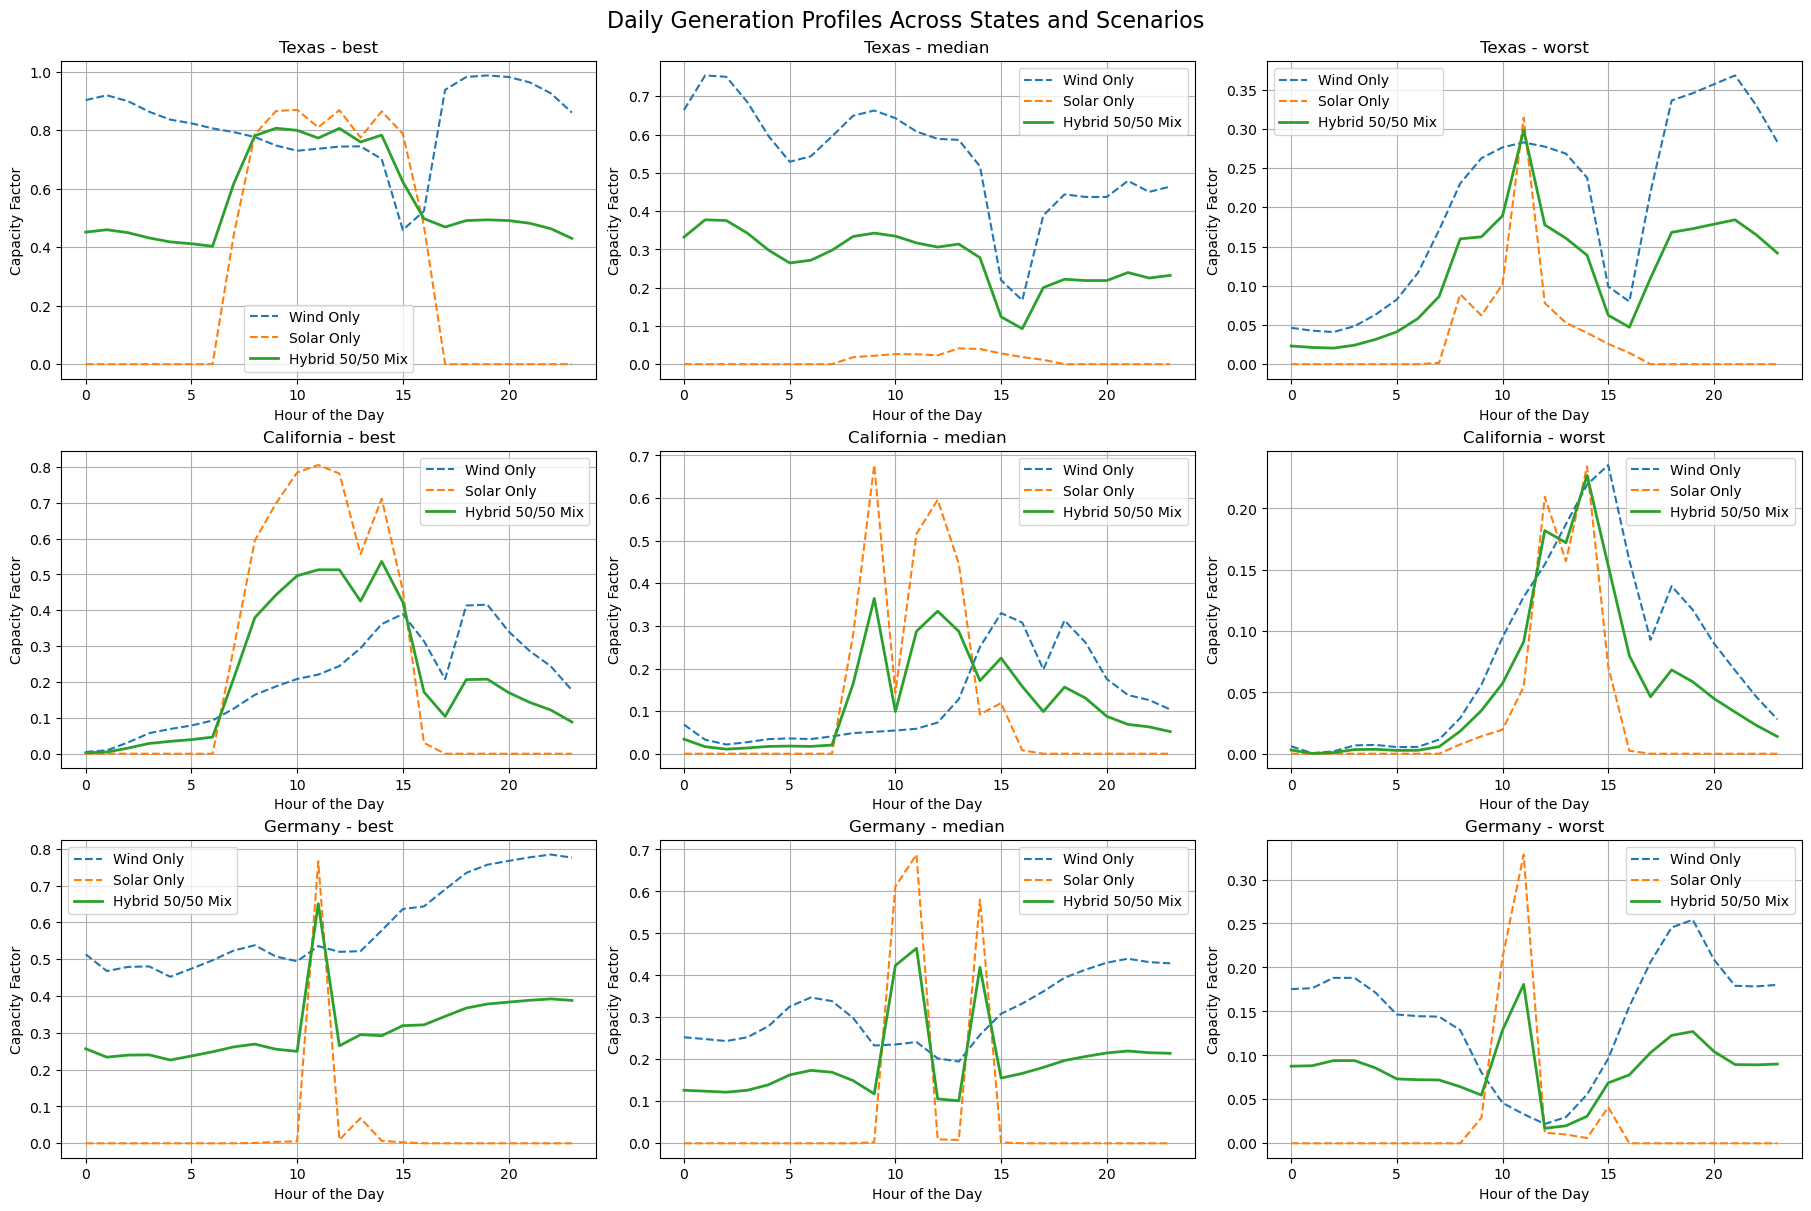

In [29]:
# First Day Test -> NOT REPRESENTATIVE
states = ['Texas', 'California', 'Germany']
scenarios = ['best', 'median', 'worst']

fig, axs = plt.subplots(3, 3, figsize=(18, 12), constrained_layout=True)

for i, state in enumerate(states):
    for j, scenario in enumerate(scenarios):
        # Accessing wind and solar CF data for the current state and scenario
        CF_wind = combined_renewables[state][scenario]['wind']
        CF_solar = combined_renewables[state][scenario]['solar']

        # Plotting daily profiles
        hours = np.arange(24)  # One day
        axs[i, j].plot(hours, CF_wind[:24], label='Wind Only', linestyle='--')
        axs[i, j].plot(hours, CF_solar[:24], label='Solar Only', linestyle='--')
        axs[i, j].plot(hours, 0.5 * CF_wind[:24] + 0.5 * CF_solar[:24], label='Hybrid 50/50 Mix', linewidth=2)

        # Setting titles and labels
        axs[i, j].set_title(f'{state} - {scenario}')
        axs[i, j].set_xlabel('Hour of the Day')
        axs[i, j].set_ylabel('Capacity Factor')
        axs[i, j].legend()
        axs[i, j].grid(True)

# Display the figure with all subplots
plt.suptitle('Daily Generation Profiles Across States and Scenarios', fontsize=16)
plt.show()

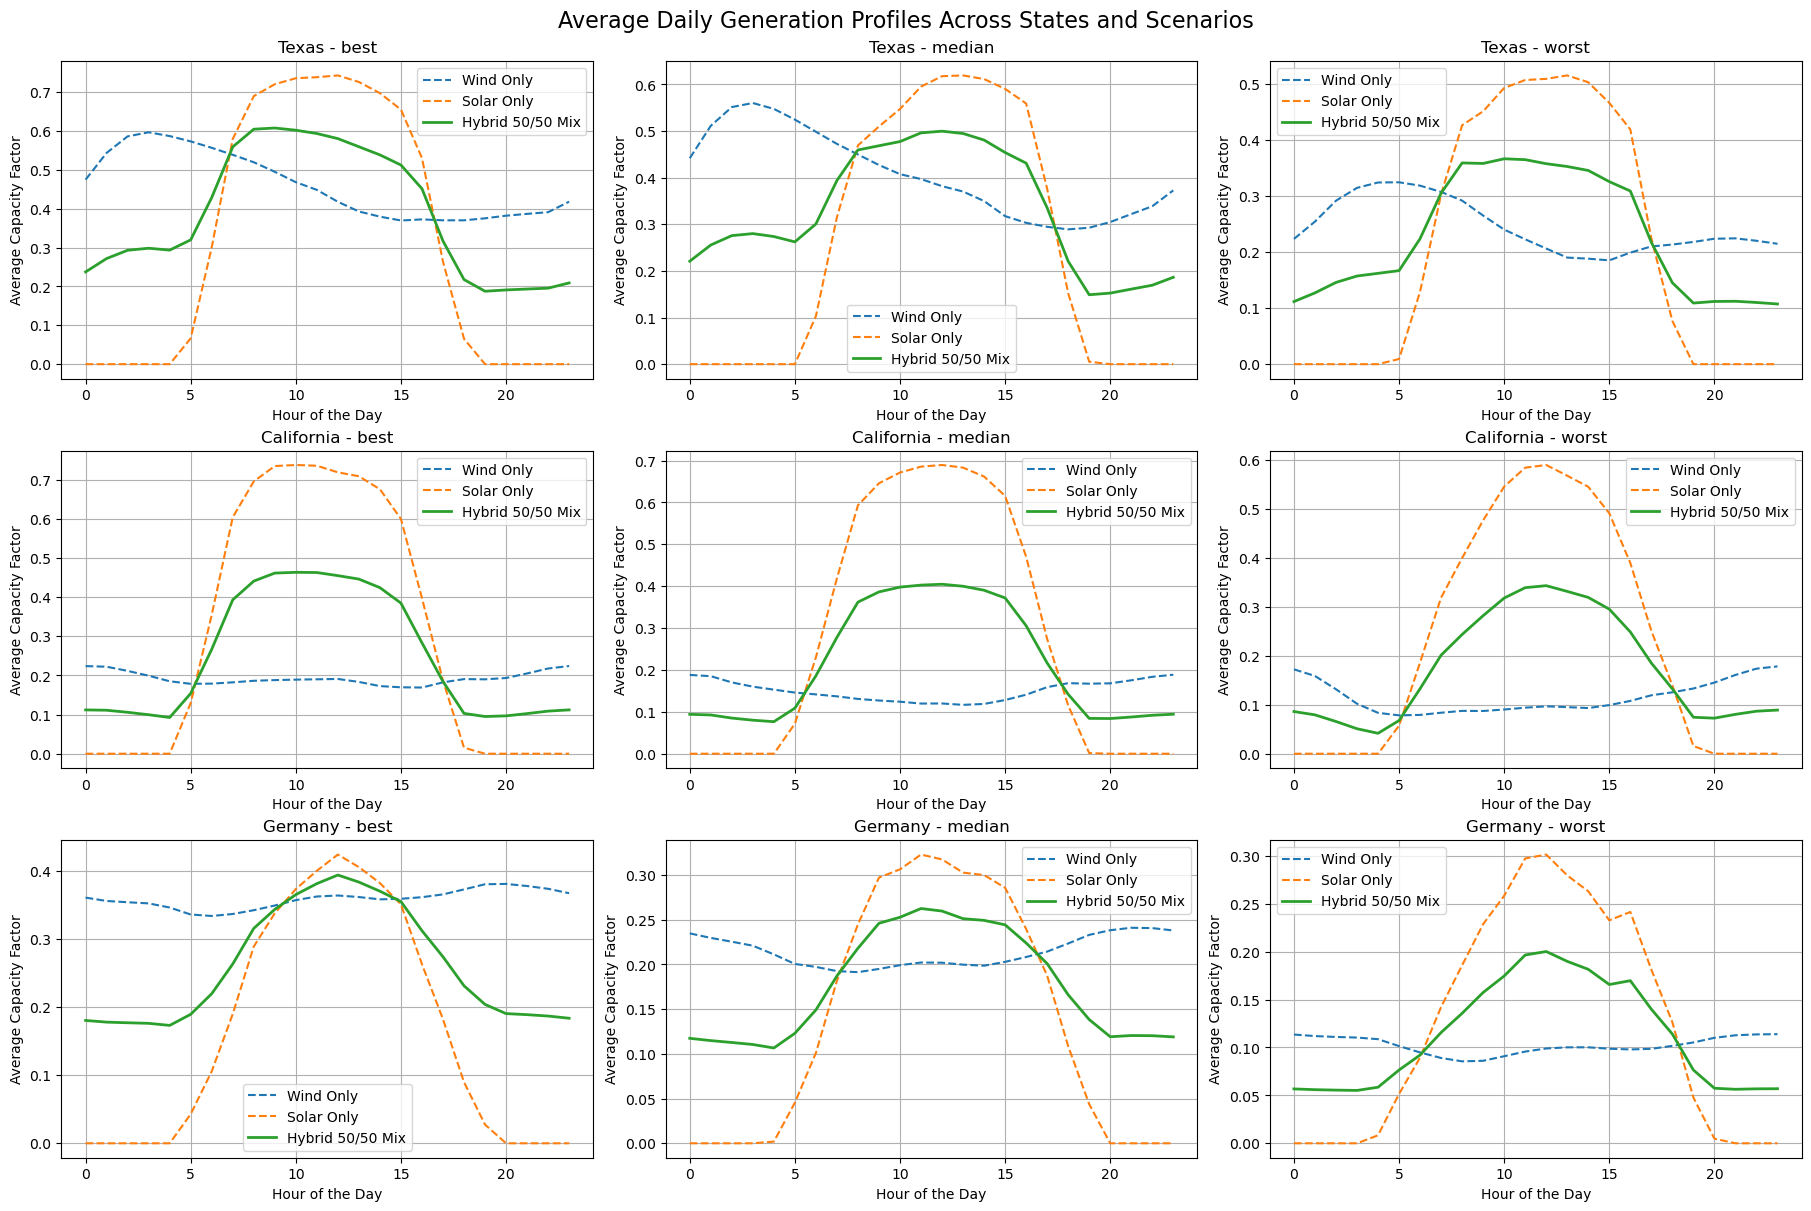

In [30]:
# Plotting average daily profiles
fig, axs = plt.subplots(3, 3, figsize=(18, 12), constrained_layout=True)
for i, state in enumerate(states):
    for j, scenario in enumerate(scenarios):
        # Ensure data is updated correctly in the loop
        CF_wind = combined_renewables[state][scenario]['wind']
        CF_solar = combined_renewables[state][scenario]['solar']

        # Calculate average daily profiles
        daily_wind = CF_wind.reshape(-1, 24).mean(axis=0)
        daily_solar = CF_solar.reshape(-1, 24).mean(axis=0)
        daily_hybrid = 0.5 * daily_wind + 0.5 * daily_solar

        # Plot average daily profiles
        hours = np.arange(24)  # One day
        axs[i, j].plot(hours, daily_wind, label='Wind Only', linestyle='--')
        axs[i, j].plot(hours, daily_solar, label='Solar Only', linestyle='--')
        axs[i, j].plot(hours, daily_hybrid, label='Hybrid 50/50 Mix', linewidth=2)

        # Setting titles and labels
        axs[i, j].set_title(f'{state} - {scenario}')
        axs[i, j].set_xlabel('Hour of the Day')
        axs[i, j].set_ylabel('Average Capacity Factor')
        axs[i, j].legend()
        axs[i, j].grid(True)

plt.suptitle('Average Daily Generation Profiles Across States and Scenarios', fontsize=16)
plt.show()

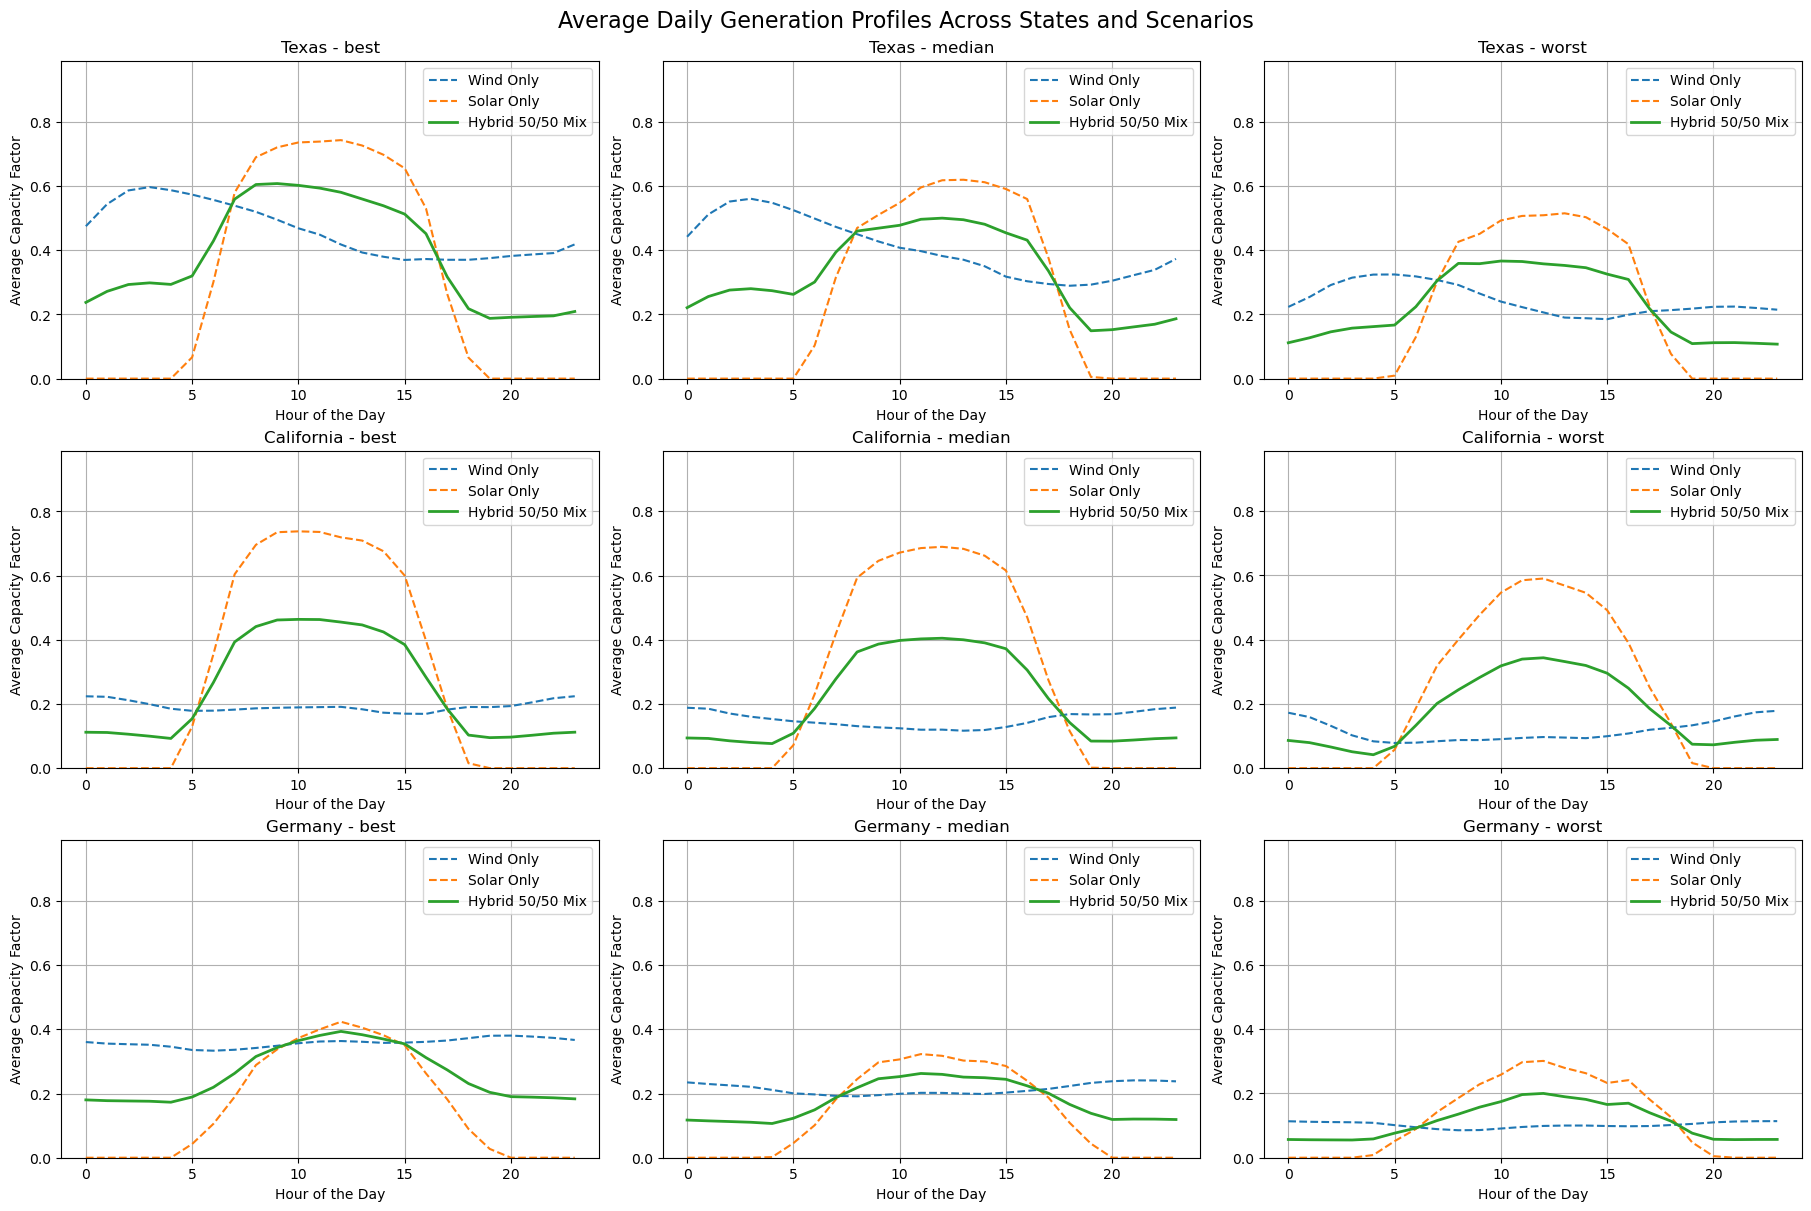

In [31]:
# Example state and scenario configuration
states = ['Texas', 'California', 'Germany']
scenarios = ['best', 'median', 'worst']

# Prepare to collect min and max values for y-axis standardization
y_limits = {scenario: [np.inf, -np.inf] for scenario in scenarios}

# First pass: collect data to determine y-axis limits
for state in states:
    for scenario in scenarios:
        CF_wind = combined_renewables[state][scenario]['wind']
        CF_solar = combined_renewables[state][scenario]['solar']
        # Combine wind and solar for y-limit calculations
        combined_CF = np.concatenate([CF_wind, CF_solar])
        # Update the y_limits dictionary
        y_limits[scenario][0] = min(y_limits[scenario][0], combined_CF.min())
        y_limits[scenario][1] = max(y_limits[scenario][1], combined_CF.max())

# Plotting with standardized y-axes
fig, axs = plt.subplots(3, 3, figsize=(18, 12), constrained_layout=True)
for i, state in enumerate(states):
    for j, scenario in enumerate(scenarios):
        CF_wind = combined_renewables[state][scenario]['wind']
        CF_solar = combined_renewables[state][scenario]['solar']

        # Calculate daily averages
        daily_wind = CF_wind.reshape(-1, 24).mean(axis=0)
        daily_solar = CF_solar.reshape(-1, 24).mean(axis=0)
        daily_hybrid = 0.5 * daily_wind + 0.5 * daily_solar

        # Plotting
        hours = np.arange(24)  # One day
        axs[i, j].plot(hours, daily_wind, label='Wind Only', linestyle='--')
        axs[i, j].plot(hours, daily_solar, label='Solar Only', linestyle='--')
        axs[i, j].plot(hours, daily_hybrid, label='Hybrid 50/50 Mix', linewidth=2)

        # Apply standardized y-limits for each row based on scenario
        axs[i, j].set_ylim(y_limits[scenario])

        # Setting titles and labels
        axs[i, j].set_title(f'{state} - {scenario}')
        axs[i, j].set_xlabel('Hour of the Day')
        axs[i, j].set_ylabel('Average Capacity Factor')
        axs[i, j].legend()
        axs[i, j].grid(True)

plt.suptitle('Average Daily Generation Profiles Across States and Scenarios', fontsize=16)
# Export
filename = f'Average Daily Generation Profiles Across States and Scenario_{version}.pdf'
output_path = os.path.join(path_figures, filename)
plt.savefig(output_path, dpi=1200, bbox_inches='tight')
plt.show()
